In [1]:
import copy
import sys
import time
sys.path.append('/home/diego/Dropbox/hold_noise/mpl_styles/')

import h5py
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import torch
from torch.optim import Adam

from gglm.glm.holi import MMDGLM
from gglm.glm.cimmdglm import CIMMDGLM
from gglm.glm.torchglm import TorchGLM
from sptr.sptr import SpikeTrain
from gglm.utils import shift_array
from gglm.metrics import bernoulli_log_likelihood_poisson_process
from kernel.values import KernelBasisValues
from gglm.metrics import time_rescale_transform

from signals import auto_covariance

import myplt

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
from nips import *
for key, val in paper.items():
    mpl.rcParams[key] = val
palette = dict(d='C0', ml='C2', mmd='C1')    

In [2]:
def plot_layout():
    fig = plt.figure(figsize=(12, 10))
    ax00 = plt.subplot2grid((nrows, ncols), (0, 0), rowspan=r1)
    ax01 = plt.subplot2grid((nrows, ncols), (0, 1), rowspan=r1, sharex=ax00)
    ax02 = plt.subplot2grid((nrows, ncols), (0, 2), rowspan=r1, sharex=ax00)
    ax03 = plt.subplot2grid((nrows, ncols), (0, 3), rowspan=r1)
    ax10 = plt.subplot2grid((nrows, ncols), (r1, 0), colspan=ncols - 1)
    ax11 = plt.subplot2grid((nrows, ncols), (r1, ncols - 1), colspan=1)
    ax20 = plt.subplot2grid((nrows, ncols), (r1 + r2, 0), colspan=ncols - 1, sharex=ax10)
    ax21 = plt.subplot2grid((nrows, ncols), (r1 + r2, ncols - 1), colspan=1, sharex=ax11, sharey=ax11)
    ax30 = plt.subplot2grid((nrows, ncols), (r1 + 2*r2, 0), colspan=ncols - 1, sharex=ax10)
    ax40 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 0), rowspan=r1)
    ax41 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 1), rowspan=r1)
    ax42 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 2), rowspan=r1)
    ax43 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 3), rowspan=r1)
    return fig, (ax00, ax01, ax02, ax03, ax10, ax11, ax20, ax21, ax30, ax40, ax41, ax42, ax43)

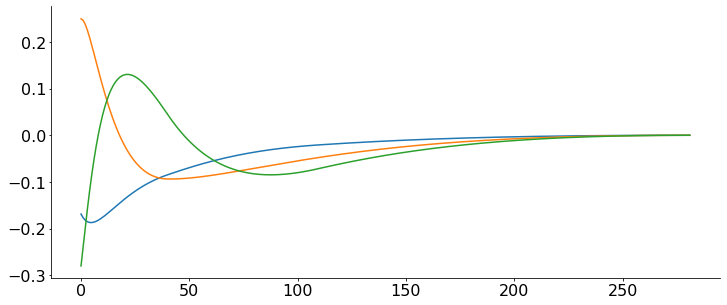

In [3]:
def raised_cosine(t, b, c, dc, a=1e0):
    basis = (1 + np.cos(np.maximum(-np.pi, np.minimum(a * (np.log(t + b) - c) * np.pi / dc / 2, np.pi)))) / 2
    basis = basis / np.sqrt(np.sum(basis**2, 0))
    u, s, v = np.linalg.svd(basis)
    basis = u[:, :basis.shape[1]]
    return basis

dt = 1
n = 3
last_peak = 40
b = last_peak / 5

peak0 = 0

yrnge = np.log(np.array([0, last_peak]) + b)
db = np.diff(yrnge) / (n - 1)
ctrs = np.arange(yrnge[0], yrnge[1] + db, db)
mxt = np.exp(yrnge[1] + 2 * db) - b
t_ker = np.arange(0, mxt[-1] + dt, dt)
# t_ker = np.arange(0,)

basis = raised_cosine(t_ker[:, None], b, ctrs[None, :], db)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(t_ker, basis)

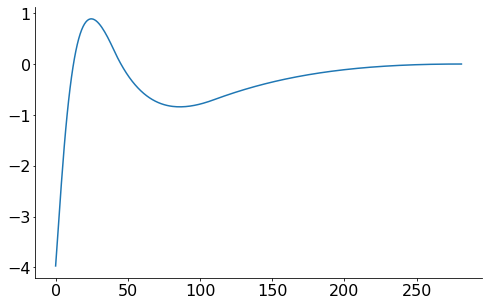

In [4]:
eta_true = KernelBasisValues(basis, [0, basis.shape[0]], dt, coefs=np.array([4., -2., 10.]))
eta_true.plot(t=t_ker)

In [5]:
from gglm.lif import LIF
from processes.ou import OUProcess

6.98


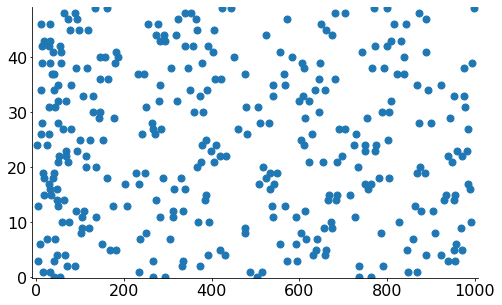

In [6]:
eta = KernelBasisValues(basis, [0, basis.shape[0]], dt, coefs=np.array([4., -2., 12.]))
eta.coefs[-1] = 20.

def gqm_filter(t, dt_last):
    return eta.interpolate(t) - 5 * np.exp(-dt_last / 200) * np.exp(-t / 75)

dt = 1
t = np.arange(0, 1000, 1)
u0 = -4.1

n = 50
shape = (len(t), n)

r = np.zeros(shape) * np.nan
eta_conv = np.zeros(shape)
mask_spikes = np.zeros(shape, dtype=bool)
last = [None] * n

j = 0
while j < len(t):

    r[j, ...] = np.exp(eta_conv[j, ...] + u0)

    p_spk = 1. - np.exp(-r[j, ...] * dt)
    aux = np.random.rand(*shape[1:])

    mask_spikes[j, ...] = p_spk > aux

    for sw in range(mask_spikes.shape[1]):
        if mask_spikes[j, sw]:
#             eta_conv[j + 1:, sw] += eta1.interpolate(t[j + 1:] - t[j + 1]) - np.exp(-np.abs(t[j] - t[last[sw]]) / 50)
            if last[sw] is None:
                eta_conv[j + 1:, sw] += gqm_filter(t[j + 1:] - t[j + 1], 5000)
            else:
                eta_conv[j + 1:, sw] += gqm_filter(t[j + 1:] - t[j + 1], t[j + 1] - t[last[sw]])
#     eta1.interpolate(t[j + 1:] - t[j + 1]) - \
#                                     5 * np.exp(-(t[j + 1] - t[last[sw]]) / 200) * np.exp(-(t[j + 1:] - t[j + 1]) / 200)
            last[sw] = j

    j += 1

print(np.mean(np.sum(mask_spikes, 0)))
st = SpikeTrain(t, mask_spikes)
n_spk = np.sum(mask_spikes)
fr = np.mean(np.sum(mask_spikes, 0) / (t[-1] - t[0] + t[1]) * 1000)
nll_pois_proc_train = -bernoulli_log_likelihood_poisson_process(mask_spikes)
autocov = np.mean(auto_covariance(mask_spikes, method='fft', subtract_mean=False, 
                                         stationary_signal=False, biased=False), 1)
isi = st.isi_distribution()
mean_isi = np.mean(isi)
st.plot()

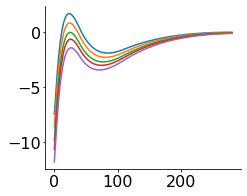

In [9]:
_t = np.arange(0, basis.shape[0], 1)
fig, ax = plt.subplots()
for dt in [400, 200, 100, 50, 0]:
    y = gqm_filter(_t, dt)
    ax.plot(_t, y)

 epoch 1499 of 1500 nll 1860.7129

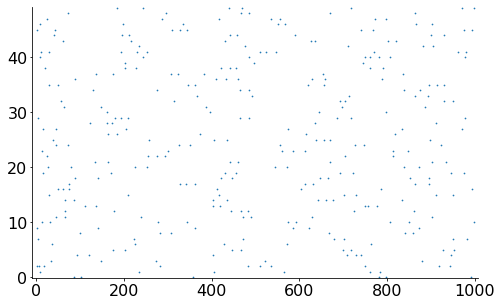

In [8]:
lr = 5e-1
num_epochs = 1500
metrics_kwargs = dict(n_batch_fr=60)
n_metrics = 10

# u00 = -3
# eta0 = KernelBasisValues(basis, [0, basis.shape[0]], dt, coefs=np.array([1., -3., 5.]))

u00 = -4.1
eta0 = eta.copy()

glm = TorchGLM(u0=u00, eta=eta0.copy(), noise='bernoulli')
optim = Adam(glm.parameters(), lr=lr)
loss_ml, metrics_ml = glm.train(st.t, st.mask, optim=optim, num_epochs=num_epochs, 
                                verbose=True, metrics=None)
loss_ml = np.array(loss_ml)
iterations_ml = np.arange(1, num_epochs + 1, 1)
nll_normed_ml = (loss_ml - nll_pois_proc_train) / np.log(2) / n_spk

_, r_dc_ml = glm.sample_conditioned(st.t, st.mask)
_, _, mask_spikes_ml = glm.sample(st.t, shape=(st.mask.shape[1], ))
st_fr_ml = SpikeTrain(st.t, mask_spikes_ml)
st_fr_ml.plot(ms=0.7)
# phi_d = phi_autocov(st.t, torch.from_numpy(r_dc_ml), glm)
# mmd_ml = []
# for ii in range(20):
#     _, r_fr_ml, mask_spikes_fr_ml = glm.sample(st.t, shape=(st.mask.shape[1],))
#     phi_fr = phi_autocov(st.t, torch.from_numpy(r_fr_ml), glm)
#     mmd_ml.append(torch.sum((torch.mean(phi_d, 1) - torch.mean(phi_fr, 1))**2).detach().numpy())

# mean_mmd_ml = np.mean(mmd_ml)
# sd_mmd_ml = np.std(mmd_ml)
# se_mmd_ml = sd_mmd_ml / len(mmd_ml)

In [10]:
from torch.nn.functional import conv1d

def ker(t, mask_spikes1, mask_spikes2, sd2):
    cum1 = torch.cumsum(mask_spikes1, dim=0)
    cum2 = torch.cumsum(mask_spikes2, dim=0)
    gramian = torch.exp(-torch.sum((cum1[:, :, None] - cum2[:, None, :])**2, dim=0) / sd2)
    return gramian

# def ker(t, mask_spikes1, mask_spikes2, sd2):
#     padding = 500
#     T = t[-1] - t[0] + t[1]
#     mask_spikes1 = mask_spikes1.double()
#     mask_spikes2 = mask_spikes2.double()
#     autocov1 = conv1d(mask_spikes1.T[None, :, :], mask_spikes1.T[:, None, :], padding=padding, groups=mask_spikes1.shape[1]) / T
#     autocov1 = autocov1[0, :, (padding - 1):].T
#     autocov2 = conv1d(mask_spikes2.T[None, :, :], mask_spikes2.T[:, None, :], padding=padding, groups=mask_spikes2.shape[1]) / T
#     autocov2 = autocov2[0, :, (padding - 1):].T
#     gramian = torch.exp(-torch.sum((autocov1[:, :, None] - autocov2[:, None, :])**2, dim=0) / sd2)
#     return gramian

idx_fr = np.triu_indices(mask_spikes_ml.shape[1], k=1)
idx_fr = (torch.from_numpy(idx_fr[0]), torch.from_numpy(idx_fr[1]))
idx_d = np.triu_indices(mask_spikes.shape[1], k=1)
idx_d = (torch.from_numpy(idx_d[0]), torch.from_numpy(idx_d[1]))

mmd_ml = []
# mmd_mmd = []

sd2_l = [1e0, 1e1, 1e2, 2e2, 5e2, 7e2, 1e3, 5e3, 1e4]
# sd2_l = [4e2, 5e2, 6e2, 7e2, 8e2, 9e2, 1e3]
# sd2_l = [1e-4, 1e-3, 1e-2, 1e-1, 1e0]
biased = False
for ii, _sd2 in enumerate(sd2_l):
    _, _, mask_spikes_ml = glm.sample(st.t, shape=(800, ))
    
    gramian_d_d = ker(t, torch.from_numpy(mask_spikes), torch.from_numpy(mask_spikes), _sd2)
    gramian_fr_fr = ker(t, torch.from_numpy(mask_spikes_ml), torch.from_numpy(mask_spikes_ml), _sd2)
    gramian_d_fr = ker(t, torch.from_numpy(mask_spikes), torch.from_numpy(mask_spikes_ml), _sd2)

    if not biased:
        _mmd_ml = torch.mean(gramian_d_d.detach()[idx_d]) + torch.mean(gramian_fr_fr.detach()[idx_fr]) \
                          - 2 * torch.mean(gramian_d_fr.detach())
    else:
        _mmd_ml = torch.mean(gramian_d_d.detach()) + torch.mean(gramian_fr_fr.detach()) \
                          - 2 * torch.mean(gramian_d_fr.detach())
    mmd_ml.append(_mmd_ml.item())
    print(ii, _sd2, _mmd_ml.item())
#     print(np.mean(mmd_ml))
print(mmd_ml)

0 1.0 -1.5709976358165666e-21
1 10.0 -5.193218299837099e-08
2 100.0 0.0015901788137853146
3 200.0 0.006841987371444702
4 500.0 0.01151391863822937
5 700.0 0.01906561851501465
6 1000.0 0.0840190052986145
7 5000.0 0.01656782627105713
8 10000.0 0.021483898162841797
[-1.5709976358165666e-21, -5.193218299837099e-08, 0.0015901788137853146, 0.006841987371444702, 0.01151391863822937, 0.01906561851501465, 0.0840190052986145, 0.01656782627105713, 0.021483898162841797]


In [27]:
def fun_metrics_mmd(model, t, mask_spikes, mask_spikes_fr):
    T = st.t[-1] - st.t[0] + st.t[1]
    u_dc, r_dc = model.sample_conditioned(st.t, st.mask)
    nll = -(np.sum(np.log(1 - np.exp(-dt * r_dc[st.mask]) + 1e-24) ) - \
                dt * np.sum(r_dc[~st.mask]))
    return dict(nll=nll)

### MMD

In [28]:
def ker_sch_heavi(t, mask_spikes1, mask_spikes2):
    T = t[-1] - t[0] + t[1]
    cum1 = torch.cumsum(mask_spikes1, dim=0)
    cum2 = torch.cumsum(mask_spikes2, dim=0)
    gramian = torch.exp(-torch.sum((cum1[:, :, None] - cum2[:, None, :])**2, dim=0) / sd2)
    return gramian

In [35]:
# phi, kernel, lam_mmd, biased, lr, clip, sd2 = None, ker_sch_heavi, 1e0, False, 1e-2, 1e0, 1e4 #1st

# phi, kernel, biased, lr, clip, sd2 = None, ker_sch_heavi, True, 2e-3, 1e0, 5e2

# phi, kernel, lam_mmd, biased, lr, clip, sd2 = None, ker_sch_heavi, 1e0, False, 2e-3, 1e0, 1e3 #1st

# phi, kernel, biased, lr, sd2 = None, ker_sch_heavi, False, 5e-3, 7e2
# phi, kernel, biased, lr, sd2 = None, ker_sch_heavi, False, 5e-3, 2e2

phi, kernel, biased, lr, sd2 = None, ker_sch_heavi, False, 1e-2, 7e2

clip = 5e-3 / lr 

beta0, beta1 = 0, 0
n_batch_fr = 200
num_epochs = 1000
n_metrics = 1

time0 = time.time()
# u00 = -6
# eta0 = KernelBasisValues(basis, [0, basis.shape[0]], dt, coefs=np.array([1., -3., 5.]))

# u00 = glm.u0 * 1.2
# eta0 = glm.eta.copy()
# eta0.coefs = eta0.coefs * 0.5

u00 = glm.u0
eta0 = glm.eta.copy()

# u00 = -4.1
# eta0 = eta1.copy()

mmdglm = MMDGLM(u0=u00, eta=eta0)
optim = Adam(mmdglm.parameters(), lr=lr, betas=(beta0, beta1))
scheduler = None

loss_mmd, nll_train, metrics_mmd = mmdglm.train(t, torch.from_numpy(mask_spikes), phi=phi, kernel=kernel, 
                                                log_likelihood=False, 
                                              n_batch_fr=n_batch_fr, biased=biased, optim=optim, clip=clip, 
                                                num_epochs=num_epochs, scheduler=scheduler, 
                                              verbose=True, metrics=fun_metrics_mmd, n_metrics=n_metrics)
loss_mmd, nll_train = np.array(loss_mmd), np.array(nll_train)
nll_normed_mmd = (metrics_mmd['nll'] - nll_pois_proc_train) / np.log(2) / n_spk
metrics_mmd['mmd'] = np.array(metrics_mmd['mmd'])
iterations_mmd = np.arange(1, num_epochs + 1, 1)

_, r_fr_mmd, mask_spikes_fr_mmd = mmdglm.sample(st.t, shape=(st.mask.shape[1],))
st_fr_mmd = SpikeTrain(st.t, mask_spikes_fr_mmd)


# _, r_dc_mmd = mmdglm.sample_conditioned(st_train.t, st_train.mask)
# isi_fr_mmd = st_fr_mmd.isi_distribution()
# mean_isi_fr_mmd = np.mean(isi_fr_mmd)
# r_dc_mmd, r_fr_mmd = r_dc_mmd * 1000, r_fr_mmd * 1000

# _, r_fr_mmd_long, mask_spikes_fr_mmd_long = mmdglm.sample(t_long, shape=(st_train.mask.shape[1],))
# st_fr_mmd_long = SpikeTrain(t_long, mask_spikes_fr_mmd_long)
# isi_fr_mmd_long = st_fr_mmd_long.isi_distribution()
# mean_isi_fr_mmd_long = np.mean(isi_fr_mmd_long)
# r_fr_mmd_long = r_fr_mmd_long * 1000
# autocov_mmd_long = np.mean(auto_covariance(mask_spikes_fr_mmd_long, method='fft', 
#                                            subtract_mean=False, stationary_signal=False, biased=False), 1)

# time1 = time.time()
# print('\n', 'took', time1 - time0, 'seconds', (time1 - time0) / 60, 'minutes')

 epoch 999 of 1000 loss -0.0965998279

In [69]:
gramian_d_d = kernel(t, torch.from_numpy(mask_spikes), torch.from_numpy(mask_spikes))
idx_d = np.triu_indices(mask_spikes.shape[1], k=1)
idx_d = (torch.from_numpy(idx_d[0]), torch.from_numpy(idx_d[1]))

mmd_ml = []
# mmd_mmd = []

for ii in range(10):
    _, _, mask_spikes_ml = glm.sample(st.t, shape=(n_batch_fr, ))

    idx_fr = np.triu_indices(mask_spikes_ml.shape[1], k=1)
    idx_fr = (torch.from_numpy(idx_fr[0]), torch.from_numpy(idx_fr[1]))
    gramian_fr_fr = kernel(t, torch.from_numpy(mask_spikes_ml), torch.from_numpy(mask_spikes_ml))
    gramian_d_fr = kernel(t, torch.from_numpy(mask_spikes), torch.from_numpy(mask_spikes_ml))

    if not biased:
        _mmd_ml = torch.mean(gramian_d_d.detach()[idx_d]) + torch.mean(gramian_fr_fr.detach()[idx_fr]) \
                          - 2 * torch.mean(gramian_d_fr.detach())
    else:
        _mmd_ml = torch.mean(gramian_d_d.detach()) + torch.mean(gramian_fr_fr.detach()) \
                          - 2 * torch.mean(gramian_d_fr.detach())
    mmd_ml.append(_mmd_ml)
print(mmd_ml)

[tensor(0.0452), tensor(0.0309), tensor(0.0300), tensor(0.0284), tensor(0.0423), tensor(0.0274), tensor(0.0375), tensor(0.0411), tensor(0.0497), tensor(0.0353)]


In [70]:
mean_mmd_ml = np.mean(mmd_ml)
sd_mmd_ml = np.std(mmd_ml)
se_mmd_ml = sd_mmd_ml / np.sqrt(len(mmd_ml))

### plot

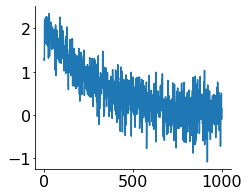

In [38]:
fig, ax = plt.subplots()
ax.plot(loss_mmd)

In [95]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

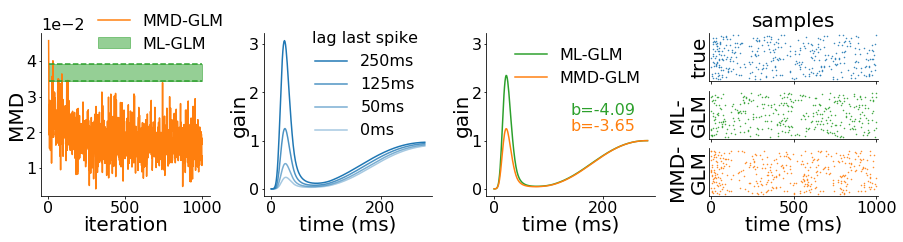

In [96]:
nrows, ncols = 3, 4

fig = plt.figure(figsize=(20 * 0.75, 4 * 0.75))
ax1 = plt.subplot2grid((nrows, ncols), (0, 0), rowspan=nrows)
ax2 = plt.subplot2grid((nrows, ncols), (0, 1), rowspan=nrows)
ax3 = plt.subplot2grid((nrows, ncols), (0, 2), rowspan=nrows, sharex=ax2, sharey=ax2)
ax4 = plt.subplot2grid((nrows, ncols), (0, 3), rowspan=1)
ax5 = plt.subplot2grid((nrows, ncols), (1, 3), rowspan=1, sharex=ax4)
ax6 = plt.subplot2grid((nrows, ncols), (2, 3), rowspan=1, sharex=ax4)

ax1.plot(iterations_mmd, metrics_mmd['mmd'], label='MMD-GLM', color=palette['mmd'])
ax1.plot([1, num_epochs], [mean_mmd_ml - se_mmd_ml, mean_mmd_ml - se_mmd_ml], '--', color=palette['ml'])
ax1.plot([1, num_epochs], [mean_mmd_ml + se_mmd_ml, mean_mmd_ml + se_mmd_ml], '--', color=palette['ml'])
ax1.fill_between([1, num_epochs], mean_mmd_ml - se_mmd_ml, mean_mmd_ml + se_mmd_ml, alpha=0.5, label='ML-GLM', color=palette['ml'])
ax1.set_xlabel('iteration')
ax1.set_ylabel('MMD')
ax1.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax1.legend(frameon=False, bbox_to_anchor=(0.25, 0.8, 0.2, 0.2))

# ax2.plot([1, num_epochs], [nll_normed_ml[-1], nll_normed_ml[-1]], '--', label='ML-GLM', color=palette['ml'])
# ax2.plot(iterations_mmd, nll_normed_mmd, label='MMD-GLM', color=palette['mmd'])
# # ax2.plot([1, num_epochs], [mean_mmd_ml - se_mmd_ml, mean_mmd_ml - se_mmd_ml], '--', color=palette['ml'])
# # ax2.plot([1, num_epochs], [mean_mmd_ml + se_mmd_ml, mean_mmd_ml + se_mmd_ml], '--', color=palette['ml'])
# myplt.set_labels(ax2, xlabel='iteration', ylabel='neg log-L (bits/spk)')
# ax2.legend(frameon=False)
# ax2.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

lw = 1.5
glm.eta.plot(t=t_ker, ax=ax3, exp_values=True, lw=lw, label='ML-GLM', color=palette['ml'])
mmdglm.eta.plot(t=t_ker, ax=ax3, exp_values=True, lw=lw, label='MMD-GLM', color=palette['mmd'])
# eta1.plot(t=t_ker, ax=ax3, exp_values=True, lw=lw, linestyle='--')
# eta2.plot(t=t_ker, ax=ax3, exp_values=True, lw=lw, linestyle='--')
ax3.text(0.5, 0.5, 'b=' + str(np.round(glm.u0, 2)), color=palette['ml'], transform=ax3.transAxes, fontsize=tick_labelsize)
ax3.text(0.5, 0.4, 'b=' + str(np.round(mmdglm.u0, 2)), color=palette['mmd'], transform=ax3.transAxes, fontsize=tick_labelsize)
# ax3.set_title('history filter')
ax3.set_xlabel('time (ms)'); ax3.set_ylabel('gain')
ax3.legend(frameon=False)

_t = np.arange(0, basis.shape[0], 1)
# fig, ax = plt.subplots()
for ii, dt in enumerate([250, 125, 50, 0]):
    y = gqm_filter(_t, dt)
    ax2.plot(_t, np.exp(y), alpha=1 - ii * 0.2, color='C0', label=str(dt)+'ms')
ax2.set_xlabel('time (ms)'); ax2.set_ylabel('gain')
ax2.legend(title='lag last spike', frameon=False, title_fontsize=tick_labelsize, loc=1, bbox_to_anchor=(1., 1.1))
    
ms = 1
ax4.set_title('samples')
ax4.set_ylabel('true')
st.plot(ax=ax4, marker='.', ms=ms, color=palette['d'])
st_fr_ml.plot(ax=ax5, marker='.', ms=ms, color=palette['ml'])
st_fr_mmd.plot(ax=ax6, marker='.', ms=ms, color=palette['mmd'])
ax5.set_ylabel('ML-\nGLM')
ax6.set_xlabel('time (ms)')
ax6.set_ylabel('MMD-\nGLM')

ax4.tick_params(axis='x', labelbottom=False)
ax4.set_yticks([])
ax5.set_yticks([])
ax5.tick_params(axis='x', labelbottom=False)
ax6.set_yticks([])

# fig.tight_layout()
fig.subplots_adjust(wspace=0.32)
fig.savefig('/home/diego/Dropbox/generative_glm/figures/fig2bbb.pdf', transparent=True, bbox_inches='tight')

(array([0.01171215, 0.00808303, 0.0008248 , 0.00016496, 0.        ,
        0.0008248 , 0.00197952, 0.00214448, 0.00313424, 0.00428896,
        0.0032992 , 0.00395904, 0.00362912, 0.00131968, 0.00131968,
        0.00049488, 0.00016496, 0.00065984, 0.00016496, 0.00032992,
        0.00016496, 0.        , 0.00016496, 0.        , 0.        ]),
 array([  4.  ,  24.48,  44.96,  65.44,  85.92, 106.4 , 126.88, 147.36,
        167.84, 188.32, 208.8 , 229.28, 249.76, 270.24, 290.72, 311.2 ,
        331.68, 352.16, 372.64, 393.12, 413.6 , 434.08, 454.56, 475.04,
        495.52, 516.  ]),
 <a list of 1 Patch objects>)

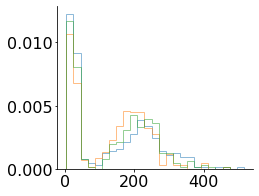

In [48]:
# print(np.mean(np.sum(mask_spikes, 0)), np.mean(np.sum(mask_spikes_ml, 0)), np.mean(np.sum(mask_spikes_fr_mmd, 0)))
# print(np.mean(np.sum(mask_spikes, 0)), np.mean(np.sum(mask_spikes_ml, 0)), np.mean(np.sum(mask_spikes_fr_mmd, 0)))
vals, bins, _ = plt.hist(st.isi_distribution(), density=True, histtype='step', alpha=0.5, bins=25)
plt.hist(st_fr_mmd.isi_distribution(), density=True, alpha=0.5, histtype='step', bins=bins)
plt.hist(st_fr_ml.isi_distribution(), density=True, alpha=0.5, histtype='step', bins=bins)

In [63]:
# dic = dict(iterations_mmd=iterations_mmd, mmd=metrics_mmd['mmd'], nll_normed_mmd=nll_normed_mmd, nll_normed_ml=nll_normed_ml, 
#            t_ker=t_ker, u0_ml=glm.u0, u0_coefs_ml=glm.eta.coefs, u0_mmd=mmdglm.u0, u0_coefs_mmd=mmdglm.eta.coefs, 
#            eta_coefs_ml=glm.eta.coefs, mask_spikes=st.mask, mask_spikes_mmd=st_fr_mmd.mask)

# import pickle
# path = './fig2'
# with open(path, "wb") as fit_file:
#     pickle.dump(dic, fit_file)

### CIMMD

In [9]:
# phi, kernel, lam_mmd, biased, lr, clip = phi_autocov, None, 5e3, True, 5e-2, 1e0

# beta0, beta1 = 0, 0
# n_batch_fr = 50
# n_metrics = 1
# num_epochs = 50

# time0 = time.time()
# u00 = -6
# eta0 = KernelBasisValues(basis, [0, basis.shape[0]], dt, coefs=np.array([1., -3., 5.]))

# mmdglm = CIMMDGLM(u0=u00, eta=eta0)
# optim = Adam(mmdglm.parameters(), lr=lr, betas=(beta0, beta1))

# loss_mmd, nll_train, metrics_mmd = mmdglm.train(t, torch.from_numpy(mask_spikes), phi=phi, kernel=kernel, 
#                                                 log_likelihood=False, score_term=False,
#                                                n_batch_fr=n_batch_fr, lam_mmd=lam_mmd, biased=biased, optim=optim, clip=clip, 
#                                                 num_epochs=num_epochs, 
#                                               verbose=True, metrics=fun_metrics_mmd, n_metrics=n_metrics)
# loss_mmd, nll_train = np.array(loss_mmd), np.array(nll_train)
# nll_normed_mmd = (metrics_mmd['nll'] - nll_pois_proc_train) / np.log(2) / n_spk
# metrics_mmd['mmd'] = np.array(metrics_mmd['mmd'])
# iterations_mmd = np.arange(1, num_epochs + 1, 1)

# # _, r_dc_mmd_train = mmdglm.sample_conditioned(st_train.t, st_train.mask)
# # z_mmd_train, ks_mmd_train = time_rescale_transform(dt, st_train.mask, r_dc_mmd_train)
# # values, bins_ks = np.histogram(np.concatenate(z_mmd_train), bins=bins_ks)
# # z_cum_mmd_val = np.append(0., np.cumsum(values) / np.sum(values))

# # _, r_dc_mmd_val = mmdglm.sample_conditioned(st_val.t, st_val.mask)
# _, r_fr_mmd, mask_spikes_fr_mmd = mmdglm.sample(st.t, shape=(st.mask.shape[1],))
# st_fr_mmd = SpikeTrain(st.t, mask_spikes_fr_mmd)
# # isi_fr_mmd = st_fr_mmd.isi_distribution()
# # mean_isi_fr_mmd = np.mean(isi_fr_mmd)
# # autocov_mmd = np.mean(auto_covariance(mask_spikes_fr_mmd, method='fft', 
# #                                            subtract_mean=False, stationary_signal=False, biased=False), 1)
# # z_mmd_val, ks_mmd_val = time_rescale_transform(dt, st_val.mask, r_dc_mmd_val)
# # values, bins_ks = np.histogram(np.concatenate(z_mmd_val), bins=bins_ks)
# # z_cum_mmd_val = np.append(0., np.cumsum(values) / np.sum(values))

# # r_dc_mmd_train, r_fr_mmd = r_dc_mmd_train * 1000, r_fr_mmd * 1000
# # r_dc_mmd_val = r_dc_mmd_val * 1000

# time1 = time.time()
# print('\n', 'took', time1 - time0, 'seconds', (time1 - time0) / 60, 'minutes')